# Similarity-Based Remaining Useful Life Estimation

## Data Preparation

In [440]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(1, '../Utils')
from rul_utils import *

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model  import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans

from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings("ignore")

In [309]:
dataset = pd.read_csv('train.txt', sep=' ', header=None,
                  names=['op_setting_1','op_setting_2','op_setting_3',
                        'sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7','sensor_8','sensor_9','sensor_10',
                        'sensor_11','sensor_12','sensor_13','sensor_14','sensor_15','sensor_16','sensor_17','sensor_18','sensor_19','sensor_20','sensor_21','sensor_22','sensor_23'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 45918 entries, (1, 1) to (218, 133)
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   op_setting_1  45918 non-null  float64
 1   op_setting_2  45918 non-null  float64
 2   op_setting_3  45918 non-null  float64
 3   sensor_1      45918 non-null  float64
 4   sensor_2      45918 non-null  float64
 5   sensor_3      45918 non-null  float64
 6   sensor_4      45918 non-null  float64
 7   sensor_5      45918 non-null  float64
 8   sensor_6      45918 non-null  float64
 9   sensor_7      45918 non-null  float64
 10  sensor_8      45918 non-null  float64
 11  sensor_9      45918 non-null  float64
 12  sensor_10     45918 non-null  float64
 13  sensor_11     45918 non-null  float64
 14  sensor_12     45918 non-null  float64
 15  sensor_13     45918 non-null  float64
 16  sensor_14     45918 non-null  float64
 17  sensor_15     45918 non-null  float64
 18  sensor_16     45

In [310]:
dataset=dataset.drop(['sensor_22','sensor_23'], axis=1)
dataset.reset_index(inplace=True)
dataset.rename(columns={'level_0':'id','level_1':'time'}, inplace=True)

In [311]:
dataset.describe().T

count         mean         std        min          25%  \
id            45918.0   109.396511   62.866193     1.0000    54.000000   
time          45918.0   110.307396   68.420545     1.0000    53.000000   
op_setting_1  45918.0    24.008881   14.793676     0.0000    10.004500   
op_setting_2  45918.0     0.571251    0.310935     0.0000     0.250600   
op_setting_3  45918.0    49.172438   32.503659     0.0000    20.000000   
sensor_1      45918.0   472.861677   26.460179   445.0000   445.000000   
sensor_2      45918.0   579.596770   37.391068   535.6500   549.580000   
sensor_3      45918.0  1419.947816  106.286960  1245.4300  1352.910000   
sensor_4      45918.0  1205.669194  119.550936  1029.4900  1124.010000   
sensor_5      45918.0     8.029878    3.627125     3.9100     3.910000   
sensor_6      45918.0    11.596773    5.451857     5.7100     5.720000   
sensor_7      45918.0   282.469820  146.539301   136.7500   139.662500   
sensor_8      45918.0  2228.406355  145.582047  1914.8500  2211.850000   
sensor_9      45918.0  8523.545525  336.780672  7988.7400  8320.740000   
sensor_10     45918.0     1.094971    0.127832     0.9300     1.020000   
sensor_11     45918.0    42.991879    3.243475    36.2100    41.930000   
sensor_12     45918.0   265.943344  138.163656   129.2400   131.360000   
sensor_13     45918.0  2334.185381  128.426495  2027.7200  2387.880000   
sensor_14     45918.0  8065.548831   84.964099  7851.5900  8061.230000   
sensor_15     45918.0     9.332433    0.751834     8.3253     8.676925   
sensor_16     45918.0     0.023354    0.004722     0.0200     0.020000   
sensor_17     45918.0   348.293915   27.837602   303.0000   331.000000   
sensor_18     45918.0  2228.342654  145.693883  1915.0000  2212.000000   
sensor_19     45918.0    97.741699    5.378969    84.9300   100.000000   
sensor_20     45918.0    20.776822    9.903697    10.2300    10.840000   
sensor_21     45918.0    12.466282    5.941954     6.1266     6.504600   

                    50%        75%        max  
id             110.0000   164.0000   218.0000  
time           106.0000   160.0000   357.0000  
op_setting_1    25.0015    41.9981    42.0080  
op_setting_2     0.7000     0.8400     0.8420  
op_setting_3    40.0000    80.0000   100.0000  
sensor_1       462.5400   491.1900   518.6700  
sensor_2       555.9850   607.3700   644.4300  
sensor_3      1369.1400  1499.6975  1614.6600  
sensor_4      1138.8700  1307.4375  1442.3600  
sensor_5         7.0500    10.5200    14.6200  
sensor_6         9.0300    15.4900    21.6100  
sensor_7       194.6300   394.1000   555.7200  
sensor_8      2223.0500  2323.9600  2388.3600  
sensor_9      8359.4350  8777.1700  9216.8300  
sensor_10        1.0200     1.2600     1.3000  
sensor_11       42.3900    45.3800    48.3900  
sensor_12      183.1700   371.2500   523.4600  
sensor_13     2388.0700  2388.1600  2390.7400  
sensor_14     8081.4750  8126.3800  8274.8800  
sensor_15        9.3145     9.3900    11.0826  
sensor_16        0.0200     0.0300     0.0300  
sensor_17      335.0000   369.0000   398.0000  
sensor_18     2223.0000  2324.0000  2388.0000  
sensor_19      100.0000   100.0000   100.0000  
sensor_20       14.8700    28.4700    39.3300  
sensor_21        8.9252    17.0842    23.5905

In [312]:
dataset.head()

id  time  op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  \
0   1     1       10.0047        0.2501          20.0    489.05    604.13   
1   1     2        0.0015        0.0003         100.0    518.67    642.13   
2   1     3       34.9986        0.8401          60.0    449.44    555.42   
3   1     4       20.0031        0.7005           0.0    491.19    607.03   
4   1     5       42.0041        0.8405          40.0    445.00    549.52   

   sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  sensor_14  \
0   1499.45   1309.95     10.52  ...     372.15    2388.13    8120.83   
1   1584.55   1403.96     14.62  ...     521.81    2388.15    8132.87   
2   1368.17   1122.49      5.48  ...     183.26    2387.95    8063.84   
3   1488.44   1249.18      9.35  ...     314.84    2388.07    8052.30   
4   1354.48   1124.32      3.91  ...     130.44    2387.89    8083.67   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  
0     8.6216       0.03        368       2319      100.0      28.58    17.1735  
1     8.3907       0.03        391       2388      100.0      38.99    23.3619  
2     9.3557       0.02        334       2223      100.0      14.83     8.8555  
3     9.2231       0.02        364       2324      100.0      24.42    14.7832  
4     9.2986       0.02        330       2212      100.0      10.99     6.4025  

[5 rows x 26 columns]

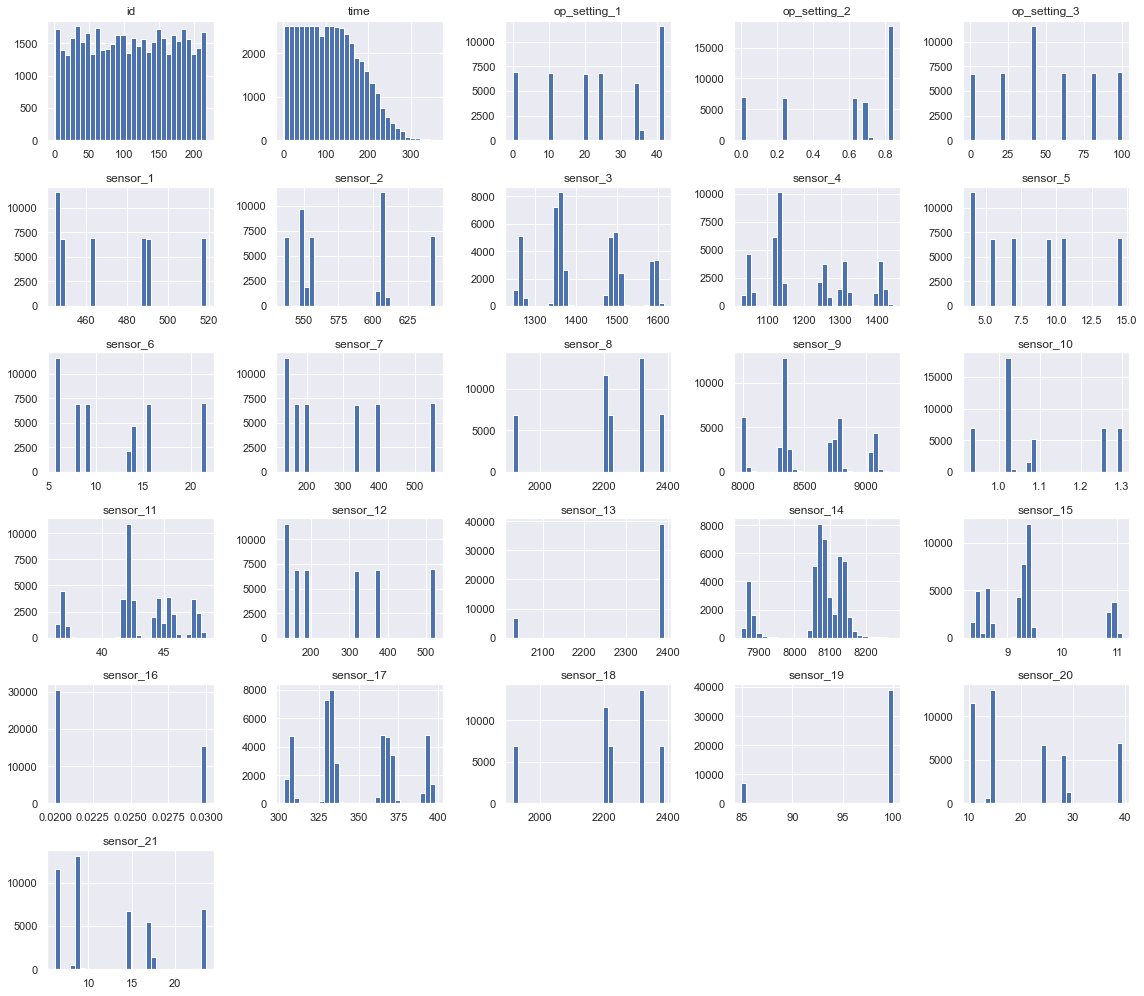

In [313]:
sns.set(font_scale=1) 
dataset.hist(bins=30, figsize=(16,14), color='b')
plt.tight_layout()
plt.show()

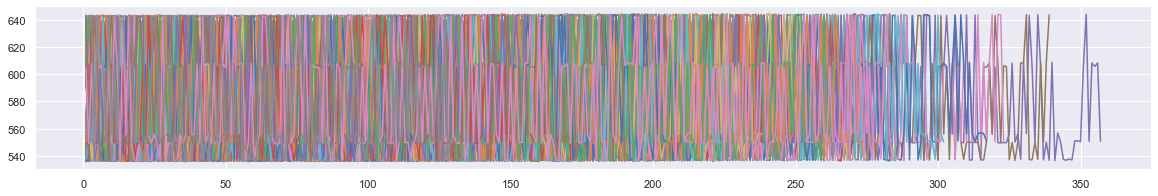

In [314]:
fig = plt.figure(figsize=(20,3))
for i in dataset.id.unique():
    plt.plot(dataset[dataset.id == i].time, dataset[dataset.id == i].sensor_2)
plt.show()

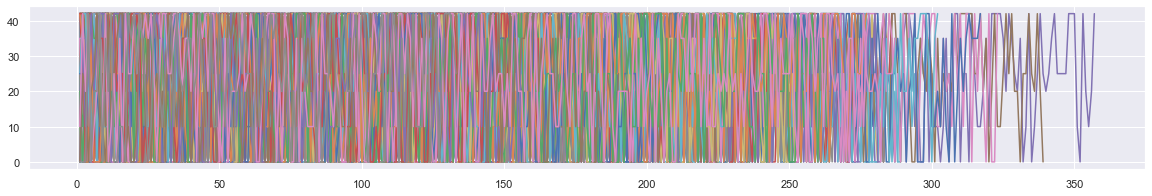

In [315]:
fig = plt.figure(figsize=(20,3))
for i in dataset.id.unique():
    plt.plot(dataset[dataset.id == i].time, dataset[dataset.id == i].op_setting_1)
plt.show()

In [316]:
df_train = dataset.copy()
sc = StandardScaler()
df_train.iloc[:,2:] = sc.fit_transform(df_train.iloc[:,2:])

In [317]:
df_train.head()

id  time  op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  \
0   1     1     -0.946643     -1.032868     -0.897522  0.611806  0.656133   
1   1     2     -1.622831     -1.836260      1.563766  1.731236  1.672429   
2   1     3      0.742874      0.864655      0.333122 -0.885177 -0.646599   
3   1     4     -0.270780      0.415682     -1.512844  0.692683  0.733692   
4   1     5      1.216426      0.865941     -0.282200 -1.052978 -0.804393   

   sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  sensor_14  \
0  0.748004  0.872280  0.686535  ...   0.768710   0.420047   0.650649   
1  1.548675  1.658648  1.816919  ...   1.851930   0.420203   0.792357   
2 -0.487156 -0.695771 -0.703010  ...  -0.598451   0.418646  -0.020113   
3  0.644415  0.363956  0.363962  ...   0.353908   0.419580  -0.155936   
4 -0.615960 -0.680464 -1.135865  ...  -0.980756   0.418179   0.213283   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  
0  -0.945475   1.407518   0.707902   0.622252   0.419844   0.787914   0.792209  
1  -1.252594   1.407518   1.534132   1.095853   0.419844   1.839048   1.833696  
2   0.030948  -0.710470  -0.513481  -0.036671   0.419844  -0.600471  -0.607683  
3  -0.145423  -0.710470   0.564210   0.656571   0.419844   0.367864   0.389929  
4  -0.045001  -0.710470  -0.657173  -0.112172   0.419844  -0.988210  -1.020514  

[5 rows x 26 columns]

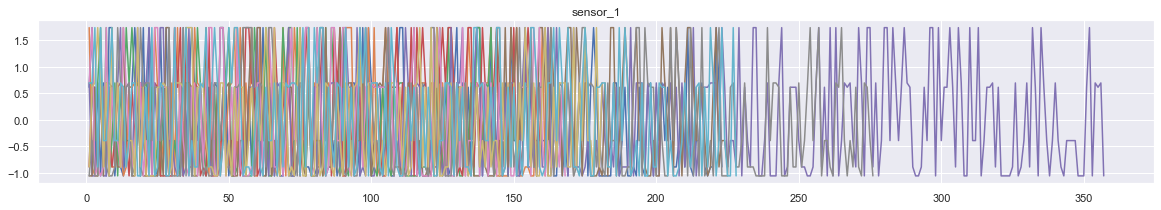

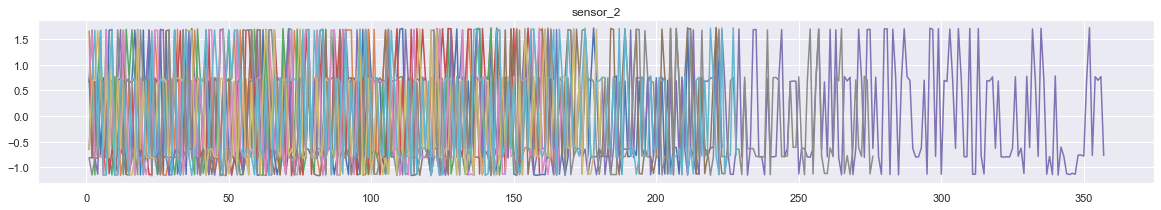

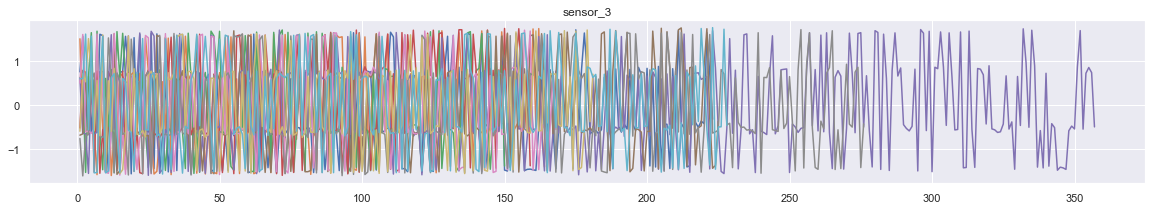

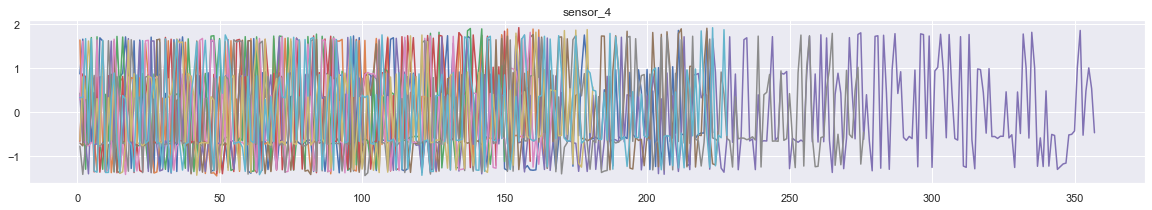

In [318]:
def vis_data(data,list_sensor,nsample):
    start = data.id.unique()[0]
    for x in list_sensor:
        fig = plt.figure(figsize=(20,3))
        plt.title(x)
        
        for i in range(start,start+nsample):
            plt.plot(data[data.id == i].time, data[data.id == i][x])
        plt.show()
    
vis_data(df_train,['sensor_1','sensor_2','sensor_3','sensor_4'],10)

# Data Preparation

In [319]:
degradationData = dataset.copy()
degradationData.head(8)

id  time  op_setting_1  op_setting_2  op_setting_3  sensor_1  sensor_2  \
0   1     1       10.0047        0.2501          20.0    489.05    604.13   
1   1     2        0.0015        0.0003         100.0    518.67    642.13   
2   1     3       34.9986        0.8401          60.0    449.44    555.42   
3   1     4       20.0031        0.7005           0.0    491.19    607.03   
4   1     5       42.0041        0.8405          40.0    445.00    549.52   
5   1     6       20.0032        0.7017           0.0    491.19    607.37   
6   1     7       41.9998        0.8400          40.0    445.00    549.57   
7   1     8        0.0011        0.0000         100.0    518.67    642.08   

   sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  sensor_14  \
0   1499.45   1309.95     10.52  ...     372.15    2388.13    8120.83   
1   1584.55   1403.96     14.62  ...     521.81    2388.15    8132.87   
2   1368.17   1122.49      5.48  ...     183.26    2387.95    8063.84   
3   1488.44   1249.18      9.35  ...     314.84    2388.07    8052.30   
4   1354.48   1124.32      3.91  ...     130.44    2387.89    8083.67   
5   1480.46   1258.90      9.35  ...     315.36    2388.05    8053.17   
6   1354.43   1131.44      3.91  ...     130.16    2387.88    8082.01   
7   1589.55   1407.59     14.62  ...     521.74    2388.03    8133.29   

   sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  
0     8.6216       0.03        368       2319      100.0      28.58    17.1735  
1     8.3907       0.03        391       2388      100.0      38.99    23.3619  
2     9.3557       0.02        334       2223      100.0      14.83     8.8555  
3     9.2231       0.02        364       2324      100.0      24.42    14.7832  
4     9.2986       0.02        330       2212      100.0      10.99     6.4025  
5     9.2276       0.02        364       2324      100.0      24.44    14.7019  
6     9.3753       0.02        331       2212      100.0      10.53     6.4254  
7     8.4339       0.03        391       2388      100.0      38.98    23.2337  

[8 rows x 26 columns]

In [320]:
degradationData.id.unique

<bound method Series.unique of 0          1
1          1
2          1
3          1
4          1
        ... 
45913    218
45914    218
45915    218
45916    218
45917    218
Name: id, Length: 45918, dtype: int64>

In [321]:
trainData = degradationData[degradationData.id <= 175].copy()
validationData = degradationData[degradationData.id > 175].copy()
trainData.shape, validationData.shape

((36953, 26), (8965, 26))

In [322]:
varNames = dataset.columns.values
timeVariable = varNames[1]
conditionVariables = varNames[2:5]
dataVariables = varNames[5:]
timeVariable, conditionVariables, dataVariables

('time',
 array(['op_setting_1', 'op_setting_2', 'op_setting_3'], dtype=object),
 array(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5',
        'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_10',
        'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15',
        'sensor_16', 'sensor_17', 'sensor_18', 'sensor_19', 'sensor_20',
        'sensor_21'], dtype=object))

# Working Regime Clustering

In [323]:
opConditionUnwrap = trainData[conditionVariables]

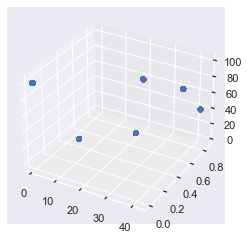

In [324]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(trainData[conditionVariables[0]],trainData[conditionVariables[1]],trainData[conditionVariables[2]])
plt.show()

In [325]:
kmeans = KMeans(n_clusters=6, random_state = 0)
kmeans.fit(opConditionUnwrap)
y_means = kmeans.predict(opConditionUnwrap)
#opConditionUnwrap['cluster'] = y_means

In [326]:
trainData['cluster'] = y_means
opConditionUnwrap_data = trainData[np.concatenate([dataVariables,['cluster']])].copy()
opConditionUnwrap_data.head()

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
0    489.05    604.13   1499.45   1309.95     10.52     15.49    394.88   
1    518.67    642.13   1584.55   1403.96     14.62     21.61    553.67   
2    449.44    555.42   1368.17   1122.49      5.48      8.00    194.93   
3    491.19    607.03   1488.44   1249.18      9.35     13.65    334.82   
4    445.00    549.52   1354.48   1124.32      3.91      5.71    138.24   

   sensor_8  sensor_9  sensor_10  ...  sensor_13  sensor_14  sensor_15  \
0   2318.87   8770.20       1.26  ...    2388.13    8120.83     8.6216   
1   2388.01   9045.76       1.30  ...    2388.15    8132.87     8.3907   
2   2222.86   8343.91       1.02  ...    2387.95    8063.84     9.3557   
3   2323.85   8721.53       1.08  ...    2388.07    8052.30     9.2231   
4   2211.80   8314.56       1.02  ...    2387.89    8083.67     9.2986   

   sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  cluster  
0       0.03        368       2319      100.0      28.58    17.1735        1  
1       0.03        391       2388      100.0      38.99    23.3619        3  
2       0.02        334       2223      100.0      14.83     8.8555        5  
3       0.02        364       2324      100.0      24.42    14.7832        4  
4       0.02        330       2212      100.0      10.99     6.4025        2  

[5 rows x 22 columns]

In [327]:
centerstats_Mean = opConditionUnwrap_data.groupby('cluster').mean()
centerstats_Mean

sensor_1    sensor_2     sensor_3     sensor_4  sensor_5   sensor_6  \
cluster                                                                        
0          462.54  536.866022  1262.757144  1050.476105      7.05   9.027578   
1          489.05  604.915092  1502.118228  1311.278176     10.52  15.493282   
2          445.00  549.715303  1354.621466  1128.135490      3.91   5.715838   
3          518.67  642.706013  1590.674154  1409.381296     14.62  21.609862   
4          491.19  607.595361  1486.008519  1253.603141      9.35  13.656846   
5          449.44  555.820024  1366.862711  1131.763863      5.48   8.000297   

           sensor_7     sensor_8     sensor_9  sensor_10  ...   sensor_12  \
cluster                                                   ...               
0        175.393618  1915.403369  8014.905016   0.939892  ...  164.563229   
1        394.330771  2318.960574  8784.210247   1.260000  ...  371.444292   
2        138.626119  2211.957558  8327.346362   1.020228  ...  130.537990   
3        553.313525  2388.102883  9062.697514   1.300000  ...  521.364739   
4        334.458211  2324.023035  8729.449879   1.077642  ...  314.848950   
5        194.435873  2223.023608  8355.262185   1.020315  ...  183.014876   

           sensor_13    sensor_14  sensor_15  sensor_16   sensor_17  \
cluster                                                               
0        2028.301014  7877.963863  10.914911   0.020000  307.372072   
1        2388.163177  8134.003351   8.665071   0.030000  369.720556   
2        2388.036854  8088.751540   9.376569   0.020000  331.109504   
3        2388.104143  8141.257203   8.443833   0.030000  393.248389   
4        2388.156385  8065.318794   9.234914   0.022319  365.426422   
5        2388.120191  8071.277797   9.333748   0.020000  334.258552   

         sensor_18  sensor_19  sensor_20  sensor_21  
cluster                                              
0           1915.0      84.93  14.262658   8.556490  
1           2319.0     100.00  28.525602  17.115649  
2           2212.0     100.00  10.583779   6.351372  
3           2388.0     100.00  38.810936  23.286003  
4           2324.0     100.00  24.448859  14.670421  
5           2223.0     100.00  14.828883   8.897827  

[6 rows x 21 columns]

In [328]:
centerstats_std = opConditionUnwrap_data.groupby('cluster').std()
centerstats_std

sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
cluster                                                                         
0             0.0  0.353349  5.278598  6.883058       0.0  0.004305  0.448665   
1             0.0  0.473666  5.819018  8.335675       0.0  0.004696  0.655193   
2             0.0  0.441707  5.663650  7.573173       0.0  0.004929  0.443624   
3             0.0  0.488569  5.948333  8.822452       0.0  0.001166  0.861418   
4             0.0  0.468204  5.765488  7.851966       0.0  0.004659  0.602514   
5             0.0  0.439361  5.671460  7.332927       0.0  0.001697  0.477076   

         sensor_8   sensor_9  sensor_10  ...  sensor_12  sensor_13  sensor_14  \
cluster                                  ...                                    
0        0.264980  14.214266   0.001034  ...   0.341990   0.279569  13.166653   
1        0.094242  17.954677   0.000000  ...   0.524908   0.095907  15.898738   
2        0.303788  18.210528   0.001493  ...   0.341671   0.327705  16.742747   
3        0.068744  20.108024   0.000000  ...   0.714143   0.069433  17.222070   
4        0.131173  18.161187   0.004245  ...   0.491484   0.133730  15.952062   
5        0.287052  17.491366   0.001746  ...   0.378257   0.308188  15.813069   

         sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
cluster                                                                     
0         0.043721   0.000000   1.314260        0.0        0.0   0.111936   
1         0.037491   0.000000   1.470130        0.0        0.0   0.144385   
2         0.036987   0.000000   1.410423        0.0        0.0   0.107826   
3         0.036629   0.000000   1.500148        0.0        0.0   0.175289   
4         0.038042   0.004221   1.443815        0.0        0.0   0.133579   
5         0.038240   0.000000   1.393185        0.0        0.0   0.111971   

         sensor_21  
cluster             
0         0.066923  
1         0.086245  
2         0.063664  
3         0.105220  
4         0.080284  
5         0.069366  

[6 rows x 21 columns]

The statistics in each regime can be used to normalize the training data. For each ensemble member, extract the **operating points** of each row, compute its distance to each cluster centers and find the nearest cluster center. Then, for each **sensor** measurement, subtract the mean and divide it by the standard deviation of that cluster. If the standard deviation is close to 0, set the normalized sensor measurement to 0 because a nearly constant sensor measurement is not useful for remaining useful life estimation.

In [329]:
def regimeNormalization(data):
    list_df = []
    Clusters = data.cluster.unique()
    for cluster in Clusters:
        each_cluster = data[data.cluster == cluster].copy()
        sc = StandardScaler()
        each_cluster.loc[:, dataVariables] = sc.fit_transform(each_cluster.loc[:,dataVariables])
        list_df.append(each_cluster)
    res_df = pd.concat(list_df)
    res_df.sort_values(by = ['id','time'], inplace=True)
    return res_df

In [330]:
trainDataNormalized = regimeNormalization(trainData)
trainDataNormalized.head()

id  time  op_setting_1  op_setting_2  op_setting_3      sensor_1  sensor_2  \
0   1     1       10.0047        0.2501          20.0 -1.136868e-13 -1.657632   
1   1     2        0.0015        0.0003         100.0  0.000000e+00 -1.179085   
2   1     3       34.9986        0.8401          60.0  5.684342e-14 -0.910551   
3   1     4       20.0031        0.7005           0.0  5.684342e-14 -1.207623   
4   1     5       42.0041        0.8405          40.0  0.000000e+00 -0.442178   

   sensor_3  sensor_4      sensor_5  ...  sensor_13  sensor_14  sensor_15  \
0 -0.458577 -0.159351  1.776357e-15  ...  -0.345965  -0.828653  -1.159613   
1 -1.029650 -0.614544  0.000000e+00  ...   0.660509  -0.487047  -1.450701   
2  0.230524 -1.264803 -8.881784e-16  ...  -0.552282  -0.470400   0.574104   
3  0.421769 -0.563368  1.776357e-15  ...  -0.646026  -0.816195  -0.310591   
4 -0.024979 -0.503844  1.776357e-15  ...  -0.448154  -0.303523  -2.108147   

      sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  \
0 -6.938894e-18  -1.170449        0.0        0.0   0.376795   0.670828   
1 -1.040834e-17  -1.498912        0.0        0.0   1.021627   0.721385   
2  3.469447e-18  -0.185600        0.0        0.0   0.009978  -0.610253   
3 -5.495079e-01  -0.988044        0.0        0.0  -0.216062   1.404888   
4  0.000000e+00  -0.786688        0.0        0.0   3.767566   0.803141   

   cluster  
0        1  
1        3  
2        5  
3        4  
4        2  

[5 rows x 27 columns]

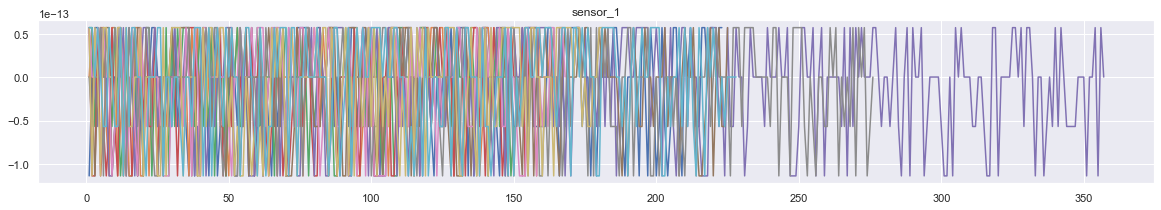

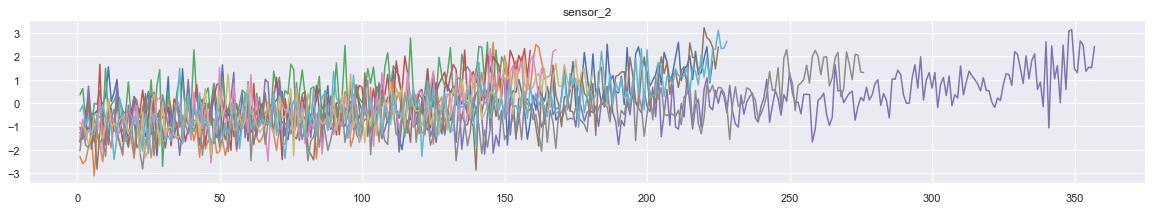

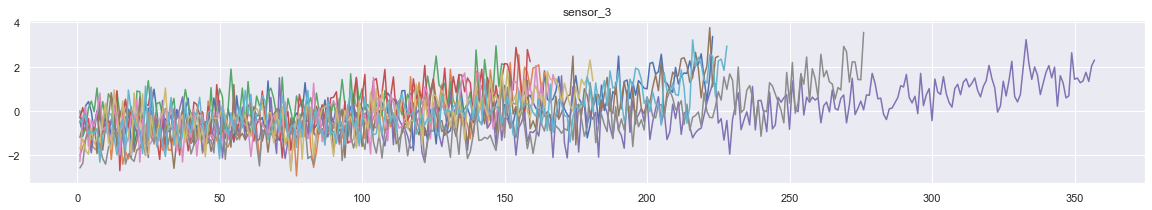

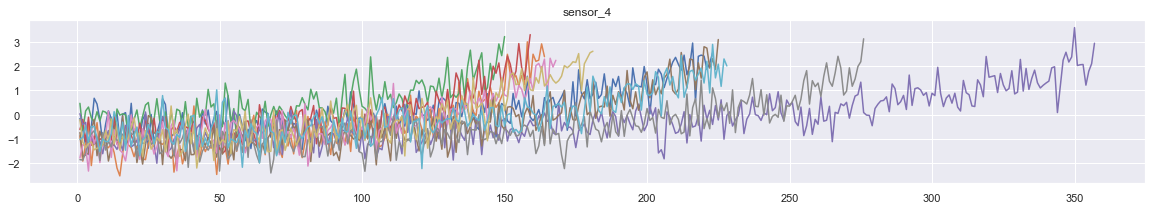

In [331]:
vis_data(trainDataNormalized,dataVariables[:4],10)

# Trendability Analysis

In [332]:
len(trainDataNormalized[trainDataNormalized.id == 2][dataVariables[2]])

164

In [333]:
slope_ranking_pd = pd.DataFrame(columns=['Sensor_id', 'Slope_value'])

In [334]:
slope_ranking_pd['Sensor_id'] = dataVariables

In [335]:
slope_ranking_pd

Sensor_id Slope_value
0    sensor_1         NaN
1    sensor_2         NaN
2    sensor_3         NaN
3    sensor_4         NaN
4    sensor_5         NaN
5    sensor_6         NaN
6    sensor_7         NaN
7    sensor_8         NaN
8    sensor_9         NaN
9   sensor_10         NaN
10  sensor_11         NaN
11  sensor_12         NaN
12  sensor_13         NaN
13  sensor_14         NaN
14  sensor_15         NaN
15  sensor_16         NaN
16  sensor_17         NaN
17  sensor_18         NaN
18  sensor_19         NaN
19  sensor_20         NaN
20  sensor_21         NaN

In [336]:
from audioop import reverse
from sklearn.linear_model import LinearRegression

def SlopeRanker(data, data_variables, nsample):
    numSensors = len(data_variables)
    signalSlope = np.zeros(numSensors)
    Final_Result = np.zeros(numSensors)
    for ct in range (numSensors):
        sum = []
        for i in range (1, 1 + nsample): 
            lr = LinearRegression()
            y = data[data.id == i][data_variables[ct]]
            y = y.values
            y = y.reshape(-1,1)
            X = data[data.id == i].time
            X = X.values
            X = X.reshape(-1,1)
            lr.fit(X,y)
            signalSlope[ct] += abs(lr.coef_)  
            Final_Result[ct] = signalSlope[ct] / nsample
            # print(f'Sensor {ct+1} in machine {i} has slope: {signalSlope[ct]}')
        # print('-')
        # print(f'Sensor {ct+1} has slope: {Final_Result[ct]}')
        # print('----------------------------------------')
    
    # signalSlope.sort()
    return Final_Result
slope_ranking = SlopeRanker(trainDataNormalized, dataVariables, 10)
slope_ranking_pd = pd.DataFrame(columns=['Sensor_id', 'Slope_value'])
slope_ranking_pd['Sensor_id'] = dataVariables
slope_ranking_pd['Slope_value'] = slope_ranking
slope_ranking_pd.sort_values(by = 'Slope_value', ascending=False, inplace=True)
slope_ranking_pd.reset_index(inplace=True)
slope_ranking_pd=slope_ranking_pd.iloc[:,1:]
slope_ranking_pd

Sensor_id   Slope_value
0   sensor_11  1.372158e-02
1    sensor_4  1.278840e-02
2   sensor_15  1.276724e-02
3    sensor_2  1.137669e-02
4   sensor_17  1.131095e-02
5    sensor_3  1.048761e-02
6   sensor_12  1.016443e-02
7    sensor_7  9.037500e-03
8   sensor_20  8.315530e-03
9   sensor_21  8.129454e-03
10  sensor_14  7.589575e-03
11   sensor_9  7.548929e-03
12  sensor_13  6.983446e-03
13   sensor_8  6.877557e-03
14   sensor_6  6.851645e-03
15  sensor_10  1.699521e-03
16  sensor_16  1.212854e-03
17   sensor_1  6.468297e-17
18  sensor_19  4.032337e-18
19   sensor_5  1.110976e-18
20  sensor_18  0.000000e+00

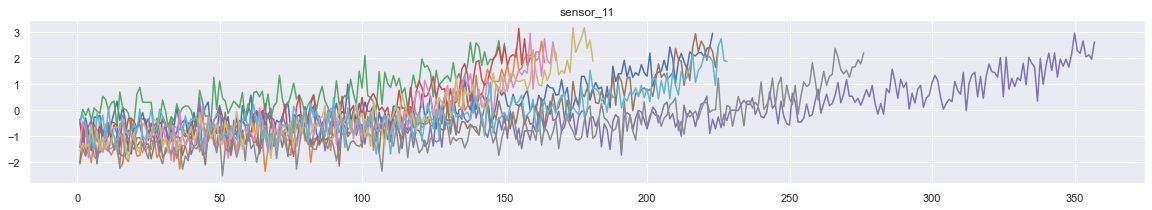

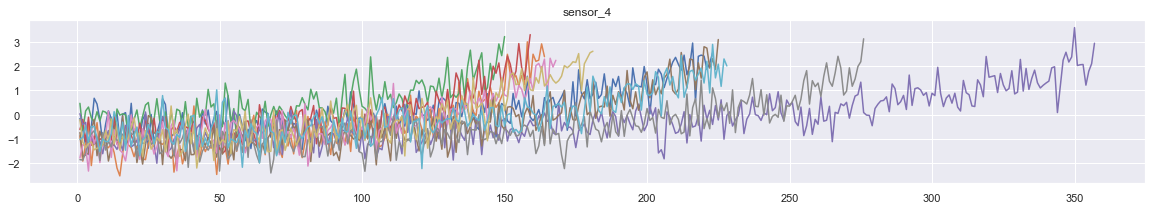

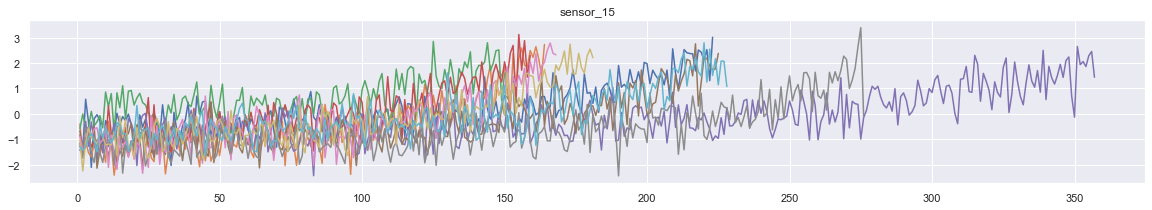

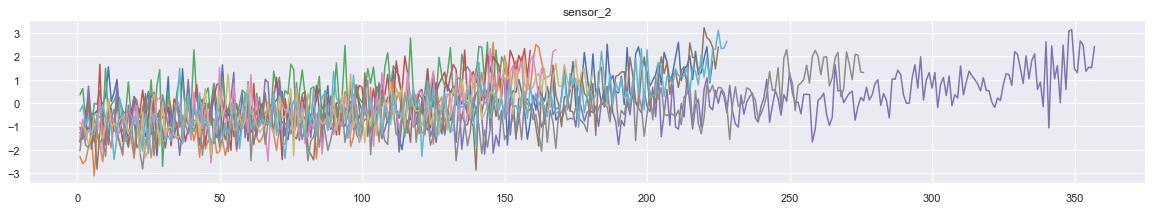

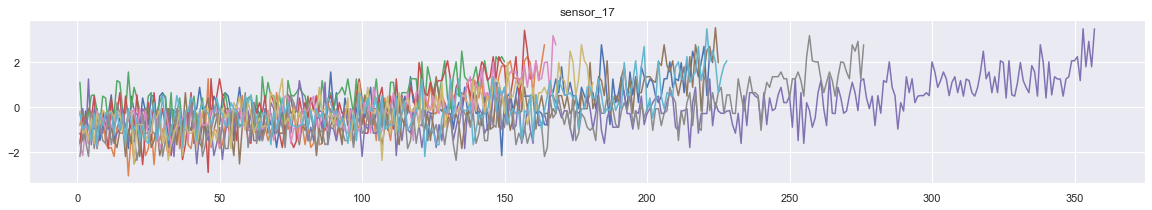

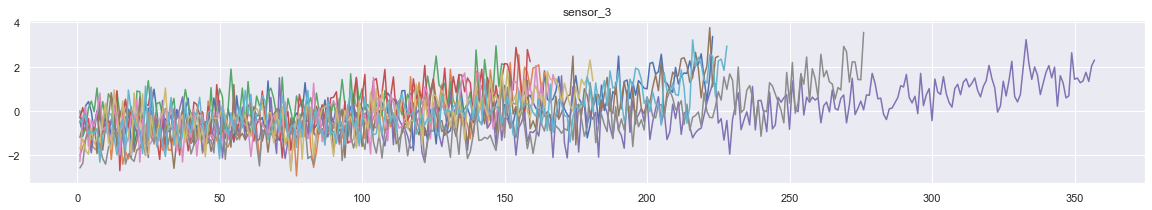

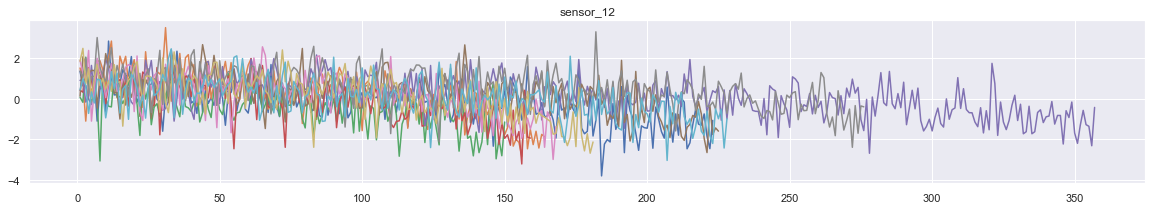

In [392]:
vis_data(trainDataNormalized,slope_ranking_pd.head(7)['Sensor_id'],10)

# Construct Health Indicator

In [338]:
ids = trainDataNormalized.id.unique()
list_df = []
for idx in ids:
    each_idx = trainDataNormalized[trainDataNormalized.id == idx].copy()
    rul = len(each_idx)
    each_idx['health'] = each_idx.apply(lambda x: 1- (x.time/rul) , axis=1)
    list_df.append(each_idx)
trainDataNormalized = pd.concat(list_df)
trainDataNormalized.head()

id  time  op_setting_1  op_setting_2  op_setting_3      sensor_1  sensor_2  \
0   1     1       10.0047        0.2501          20.0 -1.136868e-13 -1.657632   
1   1     2        0.0015        0.0003         100.0  0.000000e+00 -1.179085   
2   1     3       34.9986        0.8401          60.0  5.684342e-14 -0.910551   
3   1     4       20.0031        0.7005           0.0  5.684342e-14 -1.207623   
4   1     5       42.0041        0.8405          40.0  0.000000e+00 -0.442178   

   sensor_3  sensor_4      sensor_5  ...  sensor_14  sensor_15     sensor_16  \
0 -0.458577 -0.159351  1.776357e-15  ...  -0.828653  -1.159613 -6.938894e-18   
1 -1.029650 -0.614544  0.000000e+00  ...  -0.487047  -1.450701 -1.040834e-17   
2  0.230524 -1.264803 -8.881784e-16  ...  -0.470400   0.574104  3.469447e-18   
3  0.421769 -0.563368  1.776357e-15  ...  -0.816195  -0.310591 -5.495079e-01   
4 -0.024979 -0.503844  1.776357e-15  ...  -0.303523  -2.108147  0.000000e+00   

   sensor_17  sensor_18  sensor_19  sensor_20  sensor_21  cluster    health  
0  -1.170449        0.0        0.0   0.376795   0.670828        1  0.995516  
1  -1.498912        0.0        0.0   1.021627   0.721385        3  0.991031  
2  -0.185600        0.0        0.0   0.009978  -0.610253        5  0.986547  
3  -0.988044        0.0        0.0  -0.216062   1.404888        4  0.982063  
4  -0.786688        0.0        0.0   3.767566   0.803141        2  0.977578  

[5 rows x 28 columns]

In [394]:
len( trainDataNormalized.id.unique())

175

In [410]:
def vis_ensemble(data,list_sensor,nsample):
    start = data.id.unique()[0]
    for x in list_sensor:
        fig = plt.figure(figsize=(10,7))
        # plt.title(x)
        # plt.title('Training Data')
        plt.xlabel('Time')
        plt.ylabel('Health')
        for i in range(start,start+nsample):
            plt.plot(data[data.id == i].time, data[data.id == i][x])
        plt.show()
vis_ensemble(trainDataNormalized,['health'],len(trainDataNormalized.id.unique()))

The health condition of all ensemble members change from 1 to 0 with varying degrading speeds.

Now fit a linear regression model of Health Condition with the most trended sensor measurements as regressors:
Health Condition ~ 1 + Sensor2 + Sensor3 + Sensor4 + Sensor7 + Sensor11 + Sensor12 + Sensor15 + Sensor17

In [406]:
sensorToFuse = slope_ranking_pd.head(7)['Sensor_id'].values
X = trainDataNormalized[sensorToFuse]
y = trainDataNormalized.health
regModel = LinearRegression()
regModel.fit(X,y)
weights = regModel.coef_
weights

array([-0.06671796, -0.05368036, -0.0406921 , -0.02918746, -0.03841346,
       -0.03112457,  0.00691453])

Construct a single health indicator by multiplying the sensor measurements with their associated weights .

In [407]:
s = pd.Series(range(5))
for window in s.rolling(window=3):
    print(window)

0    0
dtype: int64
0    0
1    1
dtype: int64
0    0
1    1
2    2
dtype: int64
1    1
2    2
3    3
dtype: int64
2    2
3    3
4    4
dtype: int64


In [408]:
def degradationSensorFusion(data, sensorToFuse, weights):
    dataFused = pd.DataFrame(data = np.sum(data[sensorToFuse]*weights, axis=1), columns = ['DataFused'])
    dataFused[['id','time']] = data[['id','time']].copy()
    ids = dataFused.id.unique()
    list_df = []
    for idx in ids:
        each_idx = dataFused[dataFused.id == idx].copy()
        each_idx['DataFused'] = each_idx['DataFused'].rolling(window=21, center=True, min_periods=0).mean()
        neg = each_idx['DataFused'].values[0]
        each_idx['DataFused'] = each_idx['DataFused'] + 1 - neg
        list_df.append(each_idx)
    res_df = pd.concat(list_df)
    return res_df
trainDataFused = degradationSensorFusion(trainDataNormalized, sensorToFuse, weights)

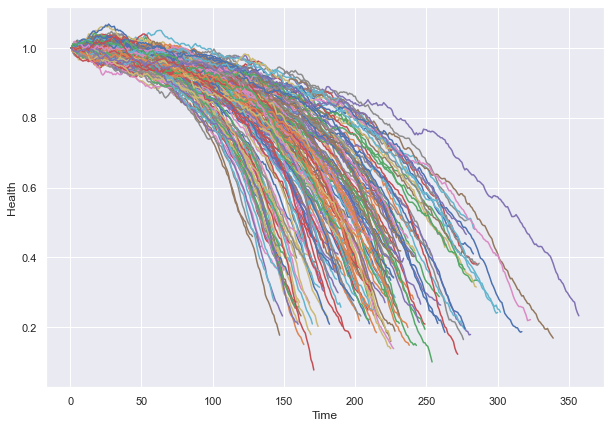

In [411]:
vis_ensemble(trainDataFused,['DataFused'],len(trainDataFused.id.unique()))

# Apply same operation to validation data

In [412]:
#Predict columns for validation data
opCondition_var = validationData[conditionVariables]
y_means_var = kmeans.predict(opCondition_var)
validationData['cluster'] = y_means_var

In [413]:
validationDataNormalized = regimeNormalization(validationData)
validataionDataToFused = degradationSensorFusion(validationDataNormalized, sensorToFuse, weights)

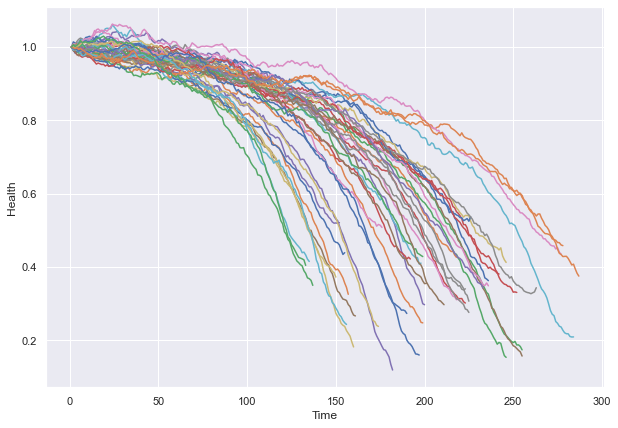

In [418]:
vis_ensemble(validataionDataToFused,['DataFused'],len(validataionDataToFused.id.unique()))

# Build Similarity RUL Model 

### Build test model 2nd order polynomial

In [416]:
trainDataFused_1 = trainDataFused[trainDataFused.id == 1].copy()
fig = plt.figure(figsize=(10,7))
plt.scatter(trainDataFused_1.time, trainDataFused_1.DataFused, s=2)

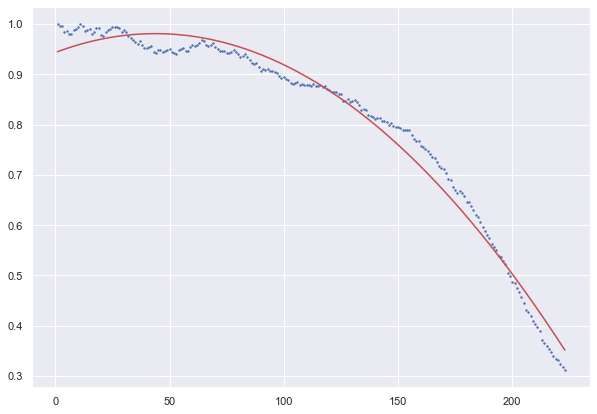

In [420]:
# fit data with a 2nd order polynomial.
p = np.polyfit(trainDataFused_1.time, trainDataFused_1.DataFused, 2)

fig = plt.figure(figsize=(10,7))
plt.scatter(trainDataFused_1.time, trainDataFused_1.DataFused, s=2, label='Train Data')
plt.plot(trainDataFused_1.time,np.polyval(p,trainDataFused_1.time), c='r', label='best fit 2nd polynomial')

### build model

In [432]:
trainDataFused.id.unique().count()

AttributeError: 'numpy.ndarray' object has no attribute 'count'

[ 13.5         13.95845846  14.41691692  14.87537538  15.33383383
  15.79229229  16.25075075  16.70920921  17.16766767  17.62612613
  18.08458458  18.54304304  19.0015015   19.45995996  19.91841842
  20.37687688  20.83533534  21.29379379  21.75225225  22.21071071
  22.66916917  23.12762763  23.58608609  24.04454454  24.503003
  24.96146146  25.41991992  25.87837838  26.33683684  26.7952953
  27.25375375  27.71221221  28.17067067  28.62912913  29.08758759
  29.54604605  30.0045045   30.46296296  30.92142142  31.37987988
  31.83833834  32.2967968   32.75525526  33.21371371  33.67217217
  34.13063063  34.58908909  35.04754755  35.50600601  35.96446446
  36.42292292  36.88138138  37.33983984  37.7982983   38.25675676
  38.71521522  39.17367367  39.63213213  40.09059059  40.54904905
  41.00750751  41.46596597  41.92442442  42.38288288  42.84134134
  43.2997998   43.75825826  44.21671672  44.67517518  45.13363363
  45.59209209  46.05055055  46.50900901  46.96746747  47.42592593
  47.88438438

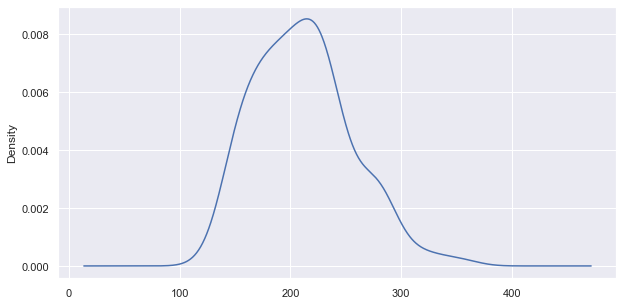

In [438]:
distributions = trainDataFused.groupby('id').size()
distributions = pd.Series(distributions)
ax = distributions.plot(kind='kde', figsize=(10, 5))
# hist_x = ax.lines[0]._x
print(hist_x)
# hist_y = ax.lines[0]._y
print(hist_y)

In [430]:
trainDataFused[trainDataFused.id == 2].copy().time.values[-1]

164

In [444]:
class residualSimilarityModel:
    
    def __init__(self):
        self.df_model = pd.DataFrame(columns = ['id','lifeSpan','poly'], index=None)
    
    def fit(self, dataTrain): # data train has many machines
        ids = dataTrain.id.unique()
        for idx in ids:
            each_id = dataTrain[dataTrain.id == idx].copy()
            poly = np.polyfit(each_id.time, each_id.DataFused, 2)
            self.df_model = self.df_model.append(pd.Series({
                'id':idx,
                'lifeSpan':each_id.time.values[-1],
                'poly':poly,
            }), ignore_index = True)
            
    def predictRUL(self, dataTest): # data test is a machine
        list_score = []
        for poly in self.df_model.poly:
            d_ij = np.linalg.norm(dataTest.DataFused - np.polyval(poly, dataTest.time),ord=1)
            score = np.exp(-d_ij**2)
#             print(score)
            list_score.append(score)
        
        df_pred = self.df_model[['id','lifeSpan']].copy()
        df_pred['score'] = list_score
        df_pred.sort_values(by = 'score',inplace=True)
        df_pred = df_pred[:50]
        
        estRUL = df_pred.lifeSpan.mean() - dataTest.time.max()
        ciRUL = [df_pred.lifeSpan.min(),df_pred.lifeSpan.max()]
        
        return estRUL, ciRUL, df_pred

In [445]:
model = residualSimilarityModel()
model.fit(trainDataFused)
test = validataionDataToFused[validataionDataToFused.id == 176].copy()
trueRUL = test.time.max()
test = test[:int(test.time.max()*0.7)]
trueRUL -= test.time.max()
estRUL, ciRUL, df_predict = model.predictRUL(test)
estRUL

73.62

In [446]:
df_test_pred = df_predict.sort_values(by = 'score', ascending=True)
df_test_pred

id lifeSpan          score
35    36      147  1.925959e-113
75    76      128  7.674760e-108
87    88      134  6.670862e-104
66    67      145   1.866918e-91
104  105      149   1.158269e-87
129  130      143   1.059012e-80
57    58      147   1.631659e-79
3      4      159   2.412228e-71
112  113      160   2.430427e-67
159  160      147   5.086625e-60
59    60      300   1.040821e-53
96    97      157   1.471126e-49
164  165      160   8.827987e-46
63    64      154   2.069095e-45
1      2      164   1.074029e-44
56    57      150   1.304702e-44
37    38      287   2.807523e-42
143  144      272   9.933871e-42
55    56      162   1.212376e-41
98    99      263   1.614302e-41
27    28      278   1.691833e-41
13    14      147   3.858819e-41
54    55      147   7.381486e-41
8      9      181   2.183461e-40
170  171      258   2.243164e-40
128  129      147   5.652169e-40
58    59      169   8.207666e-40
169  170      302   9.620437e-40
33    34      286   1.182057e-39
4      5      357   5.663094e-39
150  151      317   1.820799e-37
108  109      160   2.169642e-37
147  148      264   8.161199e-37
95    96      339   1.934276e-36
127  128      159   2.020172e-36
38    39      161   1.249427e-34
126  127      163   2.573422e-34
71    72      235   8.072413e-34
158  159      174   8.464578e-34
140  141      277   2.739965e-33
82    83      231   4.891110e-33
84    85      246   8.030836e-33
30    31      283   4.726072e-31
24    25      281   2.873996e-30
146  147      323   4.933407e-30
41    42      241   6.195386e-30
130  131      263   1.139068e-29
165  166      229   2.828553e-29
145  146      231   4.063429e-29
19    20      154   1.006263e-28

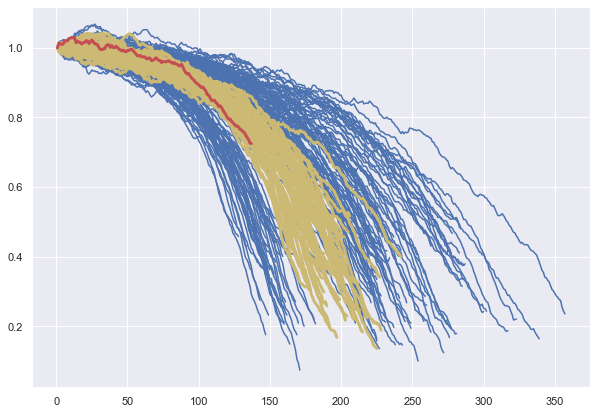

59.44

In [352]:
fig = plt.figure(figsize =(10,7))
ids = trainDataFused.id.unique()
for idx in  ids:
    each_id = trainDataFused[trainDataFused.id == idx].copy()
    plt.plot(each_id.time, each_id.DataFused, c='b')
for idx in df_test_pred.id:
    each_id = trainDataFused[trainDataFused.id == idx].copy()
    plt.plot(each_id.time, each_id.DataFused, c='y',linewidth=3)
plt.plot(test.time,test.DataFused,c='r',linewidth=3)
plt.show()
estRUL

Repeat the same evaluation procedure for the whole validation data set and compute the error between estimated RUL and true RUL for each breakpoint

In [353]:
breakpoint = {'err_5': 0.5, 'err_7': 0.7 , 'err_9': 0.9}

error = pd.DataFrame(columns = ['err_5','err_7','err_9'],index=None)

ids = validataionDataToFused.id.unique()
for idx in ids:
  
    dicIdx = {'err_5': 0, 'err_7': 0 , 'err_9':0}
    for bpIdx in breakpoint.keys():
        
        dataIdx = validataionDataToFused[validataionDataToFused.id == idx].copy()
        trueRUL = dataIdx.time.max()
        dataIdx = dataIdx[:int(dataIdx.time.max() * breakpoint[bpIdx])]
        trueRUL -= dataIdx.time.max()
        estRUL, _, _  = model.predictRUL(dataIdx)
        dicIdx[bpIdx] = estRUL - trueRUL
    error = error.append(pd.Series(dicIdx), ignore_index=True)

C:\Users\PC10\AppData\Local\Temp\ipykernel_8520\1480756687.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error = error.append(pd.Series(dicIdx), ignore_index=True)
C:\Users\PC10\AppData\Local\Temp\ipykernel_8520\1480756687.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error = error.append(pd.Series(dicIdx), ignore_index=True)
C:\Users\PC10\AppData\Local\Temp\ipykernel_8520\1480756687.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error = error.append(pd.Series(dicIdx), ignore_index=True)
C:\Users\PC10\AppData\Local\Temp\ipykernel_8520\1480756687.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  error = error.appen

In [354]:
temp = validataionDataToFused[validataionDataToFused.id == np.random.choice(validataionDataToFused.id.unique())].copy()

In [355]:
242-217

25

In [356]:
temp

DataFused   id  time
37846   1.000000  180     1
37847   1.003398  180     2
37848   0.993990  180     3
37849   1.001595  180     4
37850   1.007461  180     5
...          ...  ...   ...
38041   0.347988  180   196
38042   0.337503  180   197
38043   0.318582  180   198
38044   0.301369  180   199
38045   0.298577  180   200

[200 rows x 3 columns]

In [447]:
val_id = np.random.choice(validataionDataToFused.id.unique())
for bpIdx in breakpoint.keys():
    temp = validataionDataToFused[validataionDataToFused.id == val_id].copy()
    trueRUL = temp.time.max()
    temp = temp[:int(temp.time.max() * breakpoint[bpIdx])]
    trueRUL -= temp.time.max()
    print(model.predictRUL(temp))

(24.060000000000002, [128, 300],       id lifeSpan          score
35    36      147  1.994611e-231
75    76      128  1.635638e-210
129  130      143  2.041118e-184
87    88      134  2.049267e-174
104  105      149  2.885560e-173
66    67      145  7.029283e-151
159  160      147  5.805204e-130
57    58      147  7.575832e-123
3      4      159  3.336183e-122
1      2      164  4.031331e-121
112  113      160  2.291352e-119
120  121      153  7.402014e-118
164  165      160  1.115852e-115
56    57      150  1.150806e-115
54    55      147  7.969168e-115
13    14      147  1.810880e-114
108  109      160  2.603092e-113
128  129      147  3.179004e-101
55    56      162   1.554007e-99
132  133      151   2.759863e-95
38    39      161   1.414272e-92
153  154      171   1.344970e-88
58    59      169   1.208481e-86
19    20      154   1.677451e-83
96    97      157   2.681759e-80
63    64      154   1.723399e-74
119  120      170   3.587295e-74
158  159      174   4.218947e-72
6      7  

In [358]:
temp

DataFused   id  time
37846   1.000000  180     1
37847   1.003398  180     2
37848   0.993990  180     3
37849   1.001595  180     4
37850   1.007461  180     5
...          ...  ...   ...
38021   0.592881  180   176
38022   0.591981  180   177
38023   0.586834  180   178
38024   0.571629  180   179
38025   0.555561  180   180

[180 rows x 3 columns]

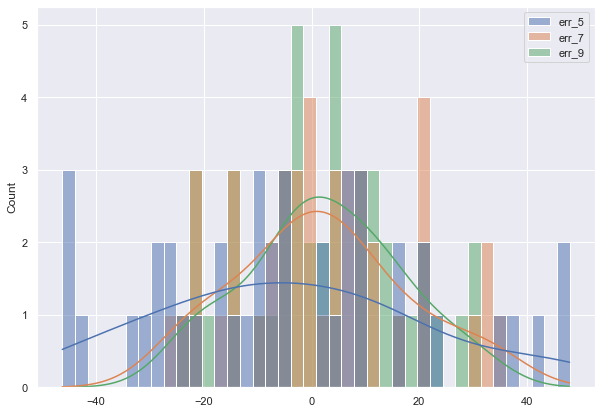

In [359]:
fig = plt.figure(figsize=(10,7))
sns.histplot(error,kde=True,bins=40)
plt.show()

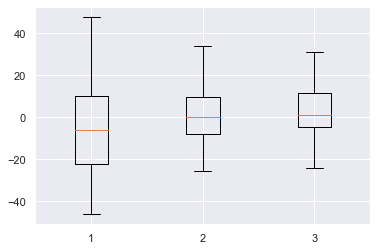

In [360]:
plt.boxplot(error)
plt.show()

In [361]:
errorMean = error.mean()
errorMean

err_5   -3.733953
err_7    1.948837
err_9    2.406977
dtype: float64

In [362]:
errorMean = error.median()
errorMean

err_5   -6.18
err_7    0.14
err_9    1.14
dtype: float64

In [363]:
errorSD = error.std()
errorSD

err_5    24.987573
err_7    15.883330
err_9    14.260763
dtype: float64

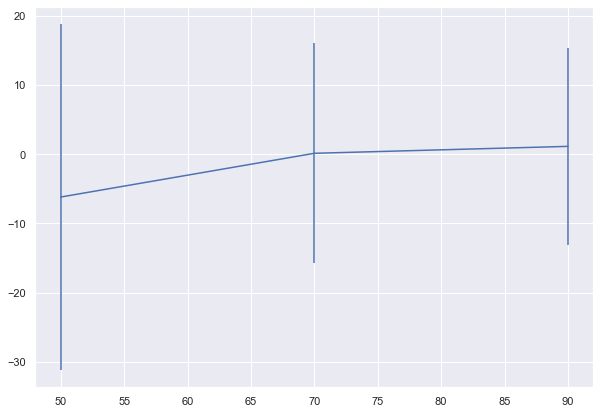

In [364]:
fig = plt.figure(figsize=(10,7))
plt.errorbar(x=[50, 70, 90], y=errorMean, yerr = errorSD)
plt.show()